# 3D-UNet网络

📑 UNet论文：[https://www.alphaxiv.org/abs/1505.04597v1](https://www.alphaxiv.org/abs/1505.04597v1)

📑 3D UNet论文：[https://www.alphaxiv.org/abs/1606.06650](https://www.alphaxiv.org/abs/1606.06650)




## 1. UNet网络

### 1.1 UNet网络结构

![alt text](assert/3DUNet/image.png)

### 1.2 UNet代码实现

In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.down5 = DoubleConv(512, 1024)

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.up1_conv = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.up2_conv = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.up3_conv = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.up4_conv = DoubleConv(128, 64)
        # self.out_conv = DoubleConv(64, out_channels)
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
        self.MaxPooling2d = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down1_out = self.down1(x)                                               # in_channel x 224 x 224 --> 64 x 224 x 224
        down2_out = self.down2(self.MaxPooling2d(down1_out))                    # 64 x 224 x 224 --> 128 x 112 x 112
        down3_out = self.down3(self.MaxPooling2d(down2_out))                    # 128 x 112 x 112 --> 256 x 56 x 56
        down4_out = self.down4(self.MaxPooling2d(down3_out))                    # 256 x 56 x 56 --> 512 x 28 x 28
        down5_out = self.down5(self.MaxPooling2d(down4_out))                    # 1024 x 14 x 14

        up1_out = self.up1(down5_out)                                           # 512 x 28 x 28
        up1_out_cat = torch.cat([up1_out, down4_out], dim=1)                    # 1024 x 28 x 28
        up1_conv_out = self.up1_conv(up1_out_cat)                               # 512 x 28 x 28

        up2_out = self.up2(up1_conv_out)                                        # 256 x 56 x 56
        up2_out_cat = torch.cat([up2_out, down3_out], dim=1)                    # 512 x 56 x 56
        up2_conv_out = self.up2_conv(up2_out_cat)                               # 256 x 56 x 56

        up3_out = self.up3(up2_conv_out)                                        # 128 x 112 x 112
        up3_out_cat = torch.cat([up3_out, down2_out], dim=1)                    # 256 x 112 x 112
        up3_conv_out = self.up3_conv(up3_out_cat)                               # 128 x 112 x 112

        up4_out = self.up4(up3_conv_out)                                        # 64 x 224 x 224
        up4_out_cat = torch.cat([up4_out, down1_out], dim=1)                    # 128 x 224 x 224
        up4_conv_out = self.up4_conv(up4_out_cat)                               # 64 x 224 x 224

        out = self.out_conv(up4_conv_out)                                       # out_channel x 224 x 224

        return out



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet(154, 4)
model.to(device)
input_tensor = torch.randn(1, 154, 224, 224)
input_tensor = input_tensor.to(device)
print(input_tensor.shape)
out = model(input_tensor)

print(out.shape)


## 2. 3D-UNet网络


### 2.1 3D-UNet网络结构

![alt text](assert/3DUNet/image-1.png)

### 2.2 3D-UNet网络代码 （Pytorch）


In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.double_conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)

        self.up1 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2)
        self.up1_conv = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.up2_conv = DoubleConv(256, 128)

        self.up3 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.up3_conv = DoubleConv(128, 64)

        self.out_conv = nn.Conv3d(64, out_channels, kernel_size=1)

        self.MaxPooling3d = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        down1_out = self.down1(x)                                               # 64 x 224 x 224 x 224
        down2_out = self.down2(self.MaxPooling3d(down1_out))                    # 128 x 112 x 112 x 112
        down3_out = self.down3(self.MaxPooling3d(down2_out))                    # 256 x 56 x 56 x 56
        down4_out = self.down4(self.MaxPooling3d(down3_out))                    # 512 x 28 x 28 x 28

        up1_out = self.up1(down4_out)                                           # 256 x 56 x 56 x 56
        up1_cat_out = torch.cat([up1_out, down3_out], dim=1)                    # 512 x 56 x 56 x 56
        up1_conv_out = self.up1_conv(up1_cat_out)                                   # 256 x 56 x 56 x 56

        up2_out = self.up2(up1_conv_out)                                        # 128 x 112 x 112 x 112
        up2_cat_out = torch.cat([up2_out, down2_out], dim=1)                    # 256 x 112 x 112 x 112
        up2_conv_out = self.up2_conv(up2_cat_out)                               # 128 x 112 x 112 x 112

        up3_out = self.up3(up2_conv_out)                                        # 64 x 224 x 224 x 224
        up3_cat_out = torch.cat([up3_out, down1_out], dim=1)                    # 128 x 224 x 224 x 224
        up3_conv_out = self.up3_conv(up3_cat_out)                               # 64 x 224 x 224 x 224

        out = self.out_conv(up3_conv_out)                                       # out_channel x 224 x 224 x 224


        return out


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D(1, 4)
model.to(device)

input_tensor = torch.randn(1, 1, 128, 128, 128).to(device)
out = model(input_tensor)
print(out.shape)

### 2.3 UNet-3D 代码实现 （Keras）

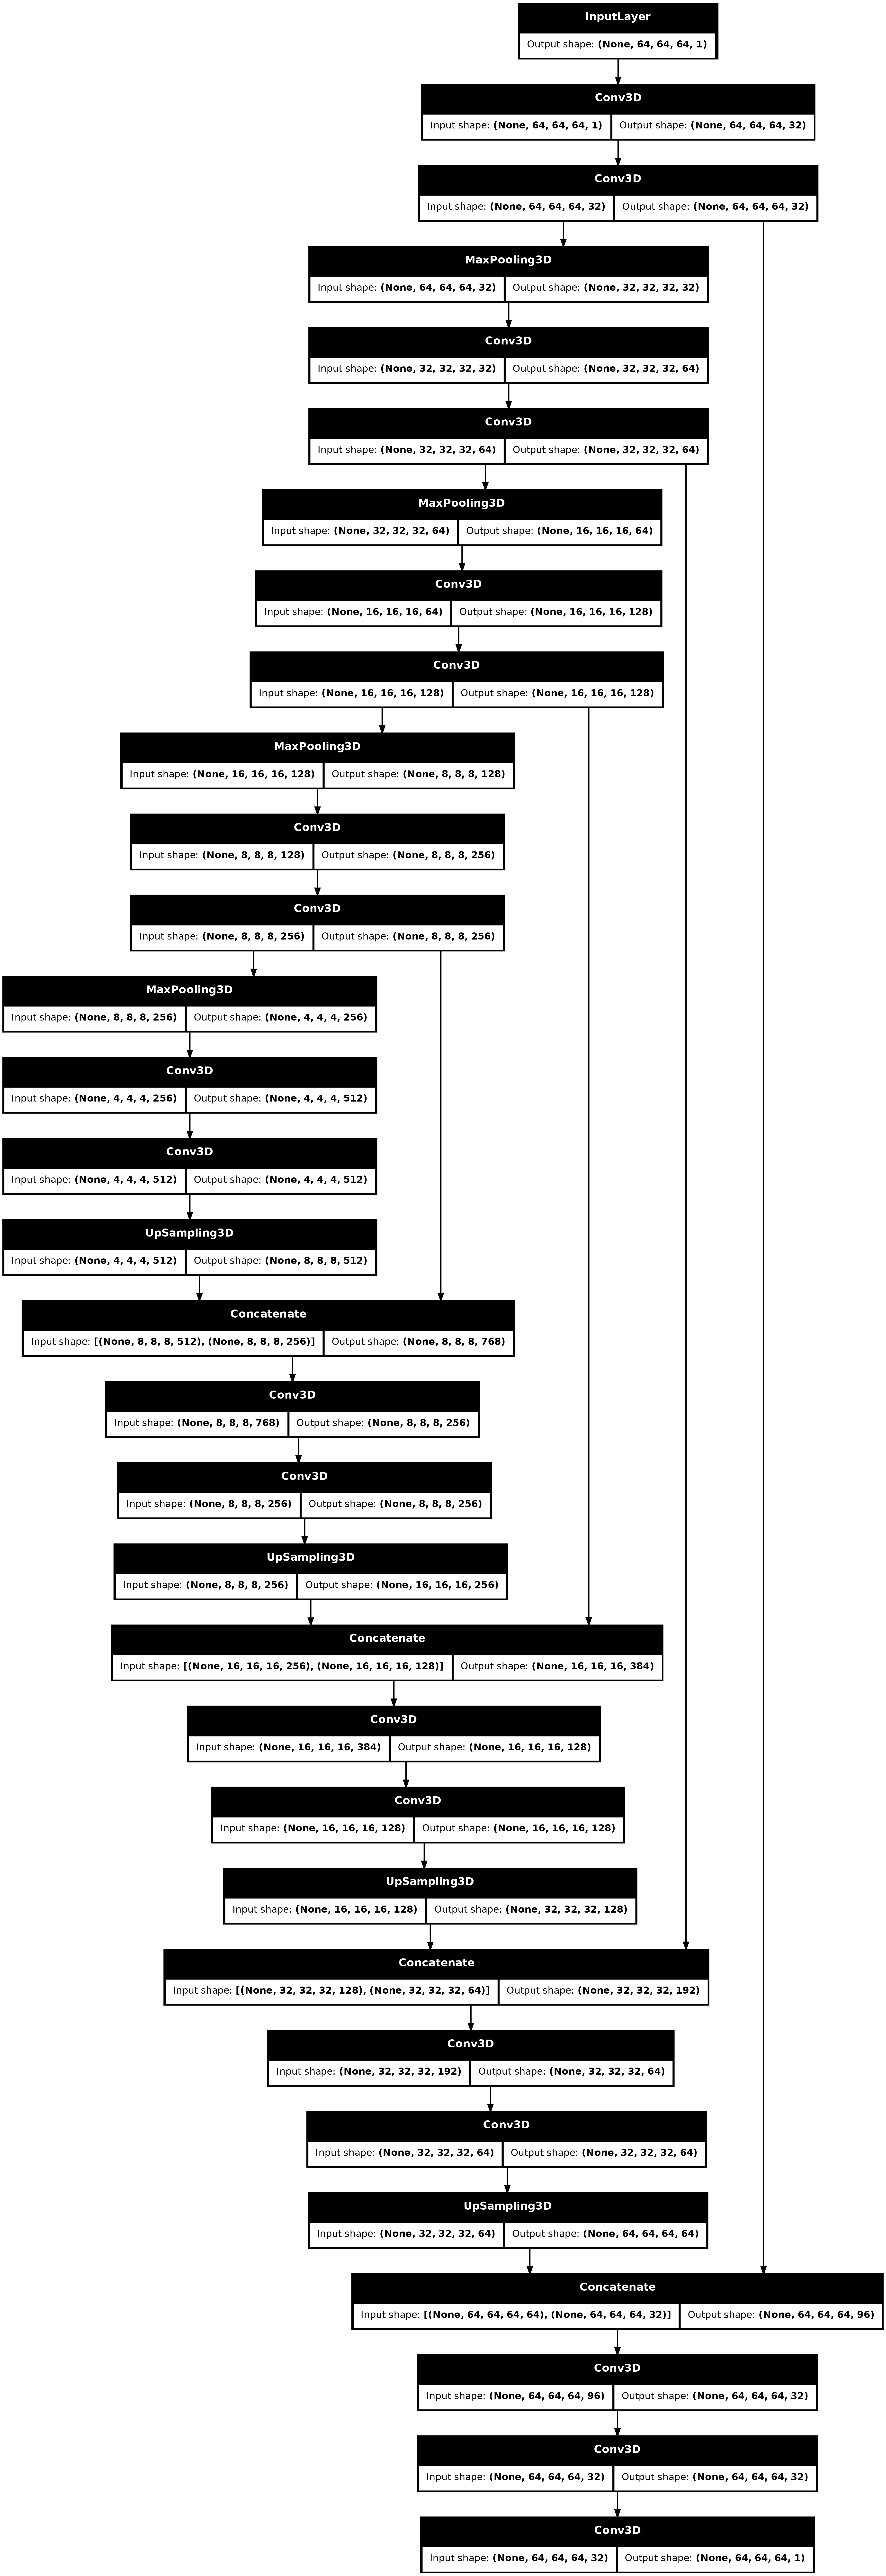

In [18]:
import keras
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate
from keras.models import Model
from keras.utils import plot_model

def unet3d(input_shape=(64, 64, 64, 1)):
    inputs = Input(input_shape)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling3D(size=(2, 2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling3D(size=(2, 2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling3D(size=(2, 2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling3D(size=(2, 2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# 创建模型
model = unet3d()

# 可视化模型
plot_model(model, to_file='unet3d.png', show_shapes=True)

Model: "functional_64"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_59      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_50       │ (None, 128, 128,  │    118,144 │ input_layer_59[0… │
│ (Sequential)        │ 128, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_25    │ (None, 64, 64,    │          0 │ sequential_50[0]… │
│ (MaxPooling3D)      │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_51       │ (None, 64, 64,    │    664,832 │ max_pooling3d_25… │
│ (Sequential)        │ 64, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_26    │ (None, 32, 32,    │          0 │ sequential_51[0]… │
│ (MaxPooling3D)      │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_52       │ (None, 32, 32,    │  2,656,768 │ max_pooling3d_26… │
│ (Sequential)        │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_27    │ (None, 16, 16,    │          0 │ sequential_52[0]… │
│ (MaxPooling3D)      │ 16, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_53       │ (None, 16, 16,    │ 10,621,952 │ max_pooling3d_27… │
│ (Sequential)        │ 16, 512)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_21 │ (None, 32, 32,    │  1,048,832 │ sequential_53[0]… │
│ (Conv3DTranspose)   │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_25      │ (None, 32, 32,    │          0 │ conv3d_transpose… │
│ (Concatenate)       │ 32, 512)          │            │ sequential_52[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_54       │ (None, 32, 32,    │  5,310,976 │ concatenate_25[0… │
│ (Sequential)        │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_22 │ (None, 64, 64,    │    262,272 │ sequential_54[0]… │
│ (Conv3DTranspose)   │ 64, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_26      │ (None, 64, 64,    │          0 │ conv3d_transpose… │
│ (Concatenate)       │ 64, 256)          │            │ sequential_51[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_55       │ (None, 64, 64,    │  1,328,384 │ concatenate_26[0… │
│ (Sequential)        │ 64, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_23 │ (None, 128, 128,  │     65,600 │ sequential_55[0]… │
│ (Conv3DTranspose)   │ 128, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_27      │ (None, 128, 128,  │          0 │ conv3d_transpose… │
│ (Concatenate)       │ 128, 128)         │            │ sequential_50[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_56       │ (None, 128, 128,  │    332,416 │ concatenate_27[0

 Total params: 22,410,436 (85.49 MB)

 Trainable params: 22,404,804 (85.47 MB)

 Non-trainable params: 5,632 (22.00 KB)

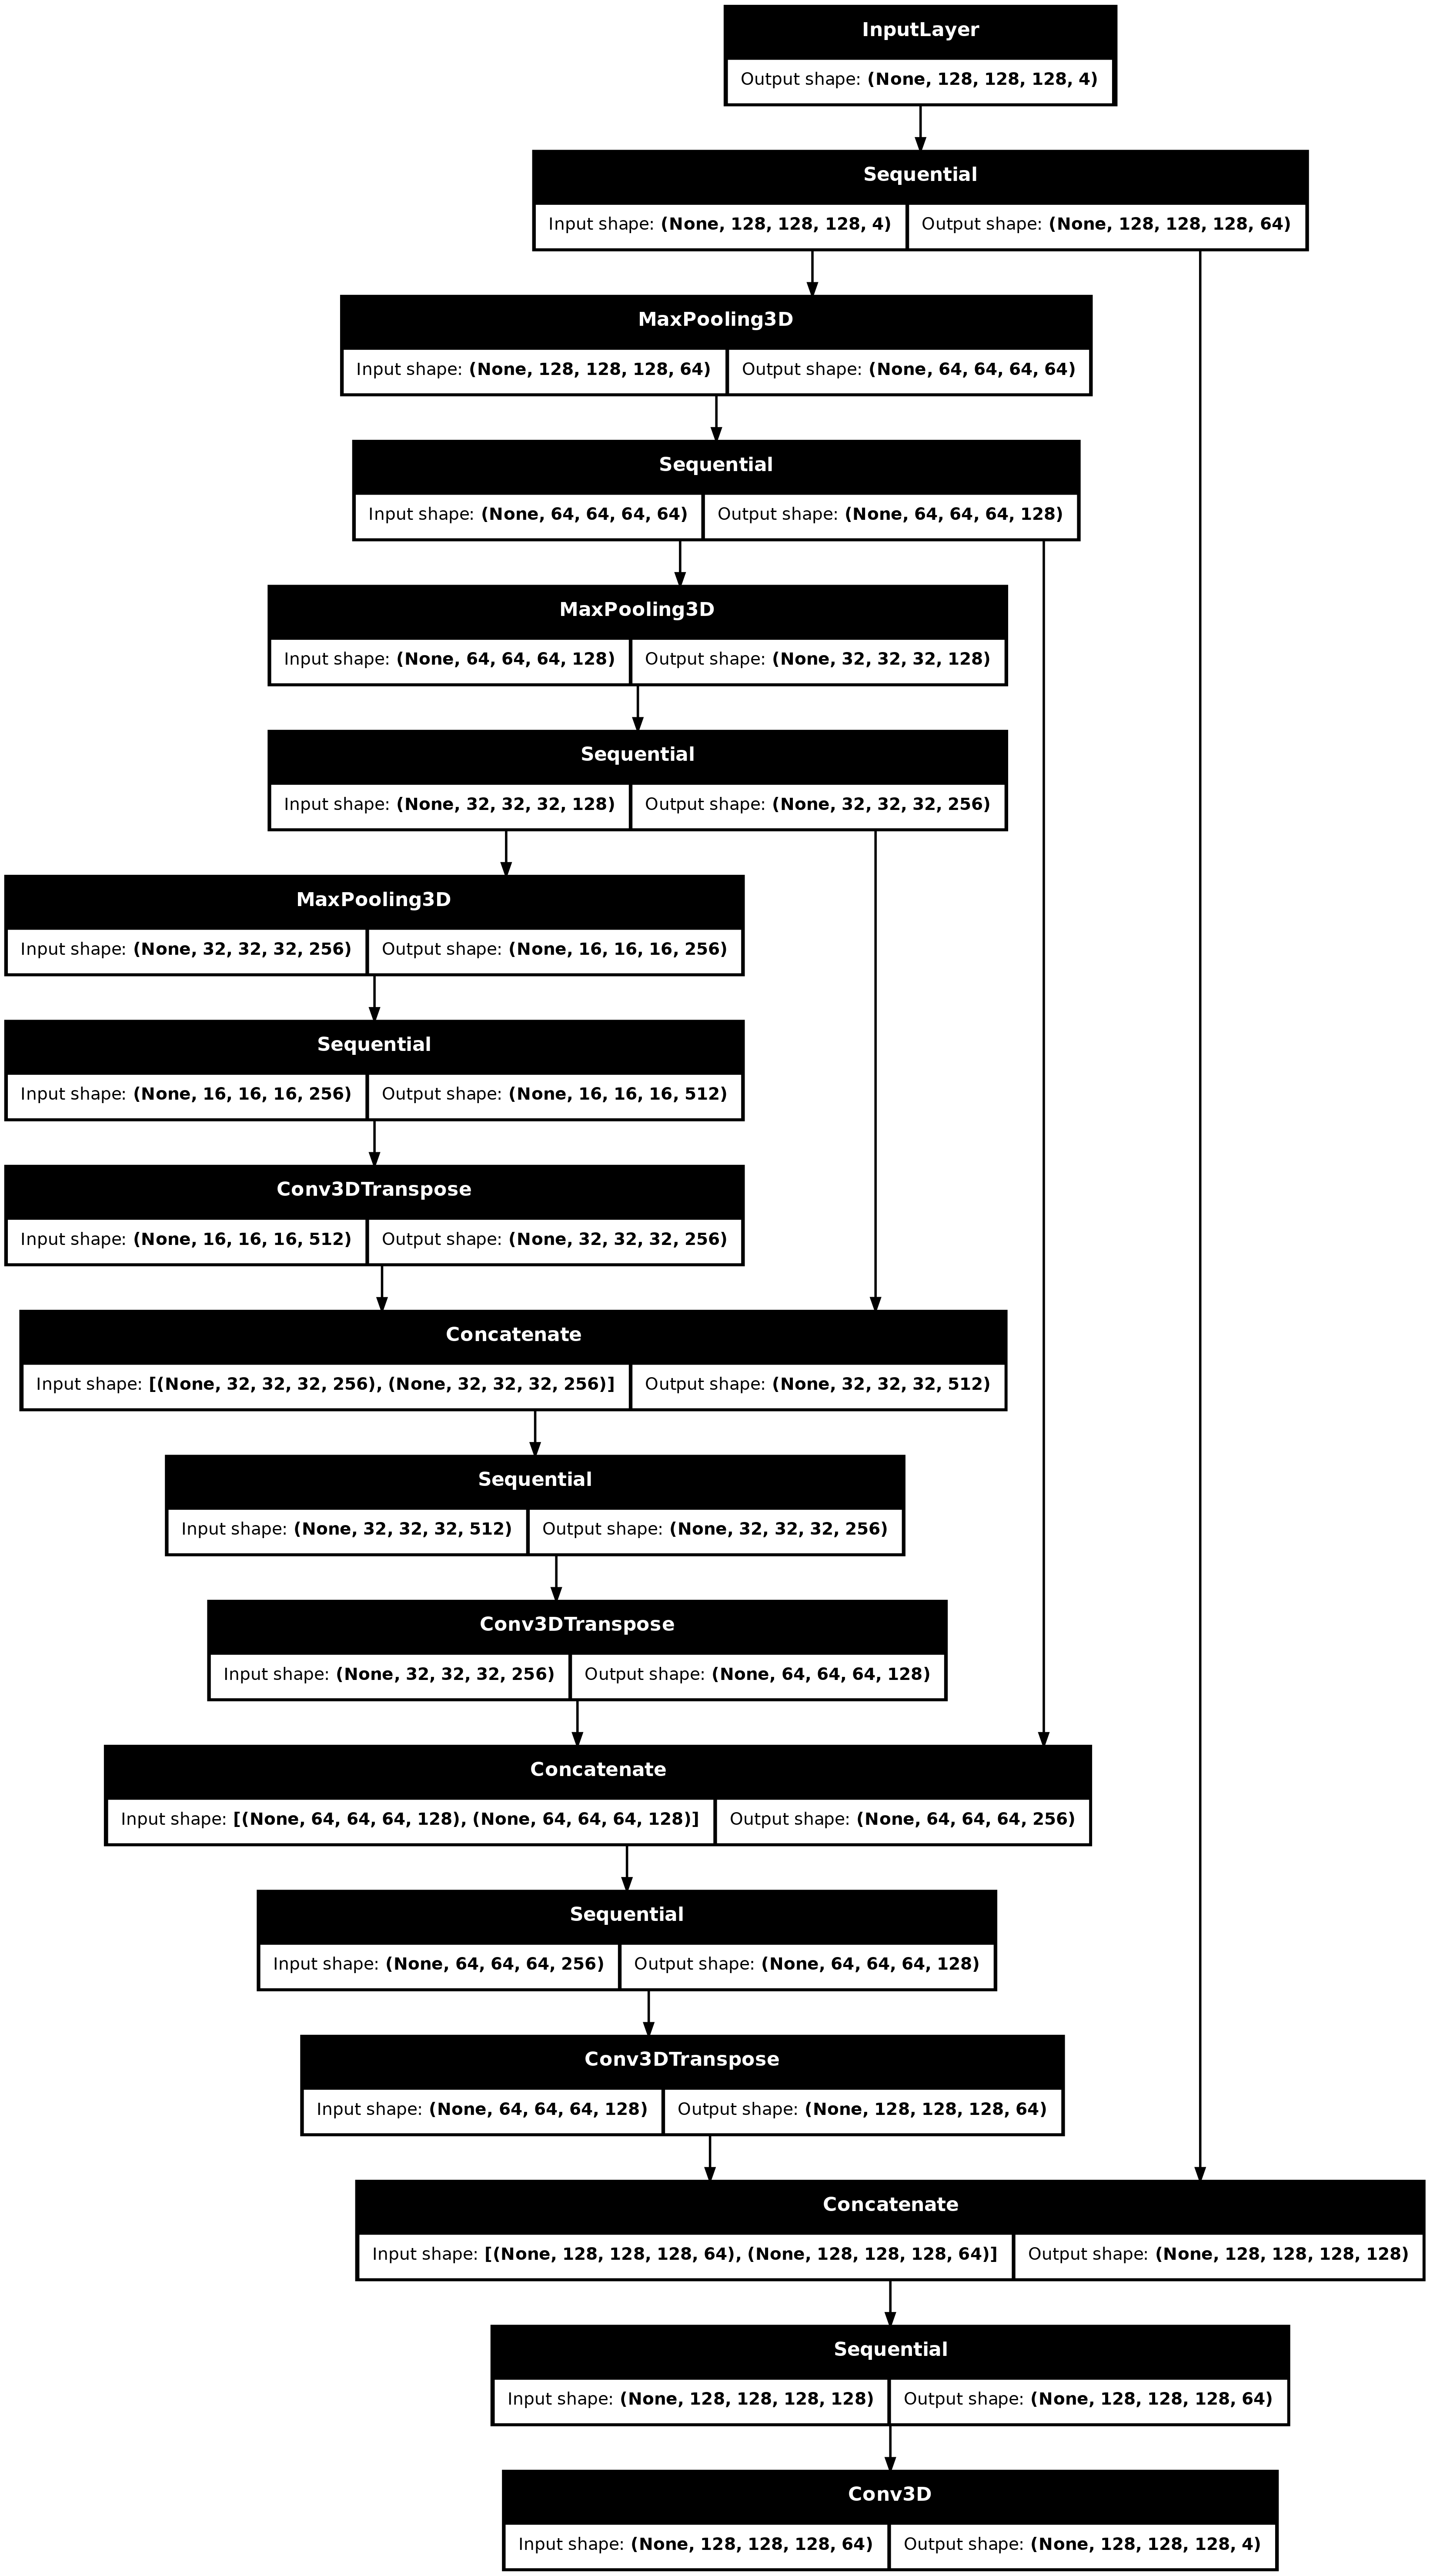

In [20]:

# 绘制模型结构图
import tensorflow as tf

device = tf.device("/GPU:0")
with device:
    # 示例使用
    model = UNet3D(in_channels=4, out_channels=4)
    input_tensor = tf.random.normal((1, 128, 128, 128, 4))

out = model(input_tensor)
out.shape
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)
